In [ ]:
%%bash
time mpirun -n 12 python weak.py

In [1]:
import sys
sys.path.append("/home/smets/code/far/PHARE/pyphare")

In [2]:
from pyphare.pharesee.run import Run
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as gf
from numpy import polyfit
from scipy.signal import find_peaks
# %matplotlib widget

`root_path` is the directory where all about "weak perturbation" is. Should not be modified

In [3]:
root_path = "/home/smets/codes/far/farMe/fluKin/weak/"

In [4]:
def get_velocities(run, times, sigma=6):
    """
    return an array (x-location) and a list of array (x-velocity) for each time in times for the ions
    """
    for it, t in enumerate(times):
        V = run.GetVi(t, merged=True)
        Vx_interpolator = V["Vx"][0]
        x_ = V["Vx"][1][0]
        if sigma >0:
            v = gf(Vx_interpolator(x_), sigma)
        else:
            v = Vx_interpolator(x_)
        if it==0 :
            Vx_ = np.zeros((len(v), len(times)))
        Vx_[:, it] = v
    return x_, Vx_

In [5]:
def get_peaks(x, Vs):
    nt = Vs.shape[1]
    positions  = np.zeros((nt, 2))
    amplitudes = np.zeros((nt, 2))
    for it in range(nt):
        ps = find_peaks(Vs[:, it], height=0.01)
        if (len(ps[0])==1):
            positions[it, 0] = x[ps[0]]
            positions[it, 1] = x[ps[0]]
            
            amplitudes[it, 0]  = Vs[ps[0][0], it]
            amplitudes[it, 1]  = Vs[ps[0][0], it]
        else:
            positions[it, 0]  = x[ps[0][0]]
            positions[it, 1]  = x[ps[0][1]]
            
            amplitudes[it, 0]  = Vs[ps[0][0], it]
            amplitudes[it, 1]  = Vs[ps[0][1], it]
    return positions, amplitudes

`path` contains a dict of electron temperatures and the name of the dir where the data are

In [6]:
# paths = {0.1: "run1",
#         }
temperature = 0.1
path = "run1"

The `profiles` function displays the velocity profiles at a set of times for a given electron temperature

In [7]:
def profiles(times, x, Ys, positions, temperature):
    fig, ax = plt.subplots()
    for it,t in enumerate(times):
        ax.plot(x, Ys[:,it], label=r"t={:6.4f}".format(t))
        ax.set_ylim((-0.03, 0.1))
        ax.axhline(0, ls='--', color='k')
        for p in positions[it,:]:
            ax.axvline(p, color="gray", ls="-.")
    ax.set_title("T = {:6.4f}".format(temperature))
    ax.legend()

Here is what is going on at `t=[0, 25, 50, 75, 100`

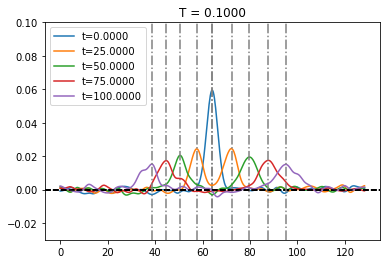

In [8]:
times   = np.asarray((0, 25, 50, 75, 100))

r = Run(root_path+"/"+path)
x, Vs   = get_velocities(r,times, sigma=6)
positions, amplitudes = get_peaks(x,Vs)
profiles(times, x, Vs, positions, temperature)

In [9]:
positions

array([[64.  , 64.  ],
       [57.5 , 72.25],
       [50.5 , 79.75],
       [44.75, 87.75],
       [38.5 , 95.  ]])

In [10]:
amplitudes

array([[0.05946046, 0.05946046],
       [0.02438136, 0.02448761],
       [0.02047579, 0.01948299],
       [0.01733727, 0.01749217],
       [0.01524079, 0.01506809]])

Amplitude is decreasing... what about the total energy contained ? does it conserve ?

In [11]:
def propagation(times, positions, temperature):
    fig,ax = plt.subplots()
    ax.plot(times,positions[:,0], marker="o", color="r", ls="None")
    vl,originl = polyfit(times, positions[:,0], 1)
    ax.plot(times, times*vl+originl, color="r")

    ax.plot(times,positions[:,1], marker="o", color="b", ls="None")
    vr,originr = polyfit(times, positions[:,1], 1)
    ax.plot(times, times*vr+originr, color="b")
    ax.set_title("T = {:6.4f}, Vl = {:6.4f}, Vr = {:6.4f}".format(temperature, vl, vr))

In [12]:
def damping(times, amplitudes, **kw):
    fig,ax = plt.subplots()
    ax.plot(times,amplitudes[:,0], marker="o", color="r", ls="None")
    ax.plot(times,amplitudes[:,1], marker="o", color="b", ls="None")
    ax.set_ylim((0,0.1))

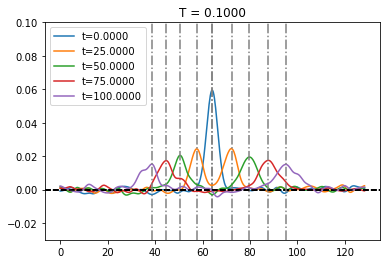

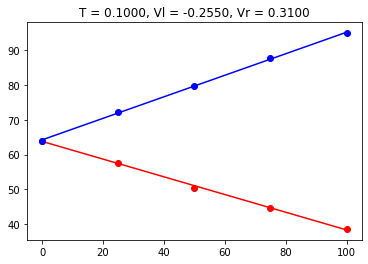

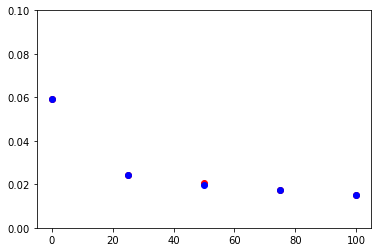

In [13]:
r = Run(root_path+"/"+path)
times   = np.asarray((0,25,50,75,100))
x, Vs   = get_velocities(r,times, sigma=6)
positions, amplitudes = get_peaks(x,Vs)
profiles(times, x, Vs, positions, temperature)
propagation(times, positions, temperature)
damping(times, amplitudes)

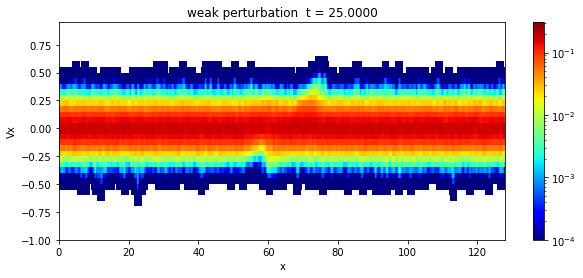

In [14]:
t=25
r = Run(root_path+"/"+path)
ions = r.GetParticles(t, ["protons",])
fig, ax1 = plt.subplots(figsize=(10,4))
p,f = ions.dist_plot(axis=("x", "Vx"), # default is [Vx,Vy]
                     ax=ax1,           # default creates the figure
                     norm = 0.4,       # max value, min is 0
                     finest=True,      # only consider finest particles possible
                     gaussian_filter_sigma=1,
                     vmin=-1,vmax=1,
                     dv=0.05,
                     title="weak perturbation  t = {:.4f}".format(t), # figure title
                    )